<a href="https://colab.research.google.com/github/nicholas-dinicola/MNIST_CNN_Optimization/blob/main/TunedCNNModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CNN Model and Optimize it using Keras Tuner

In [ ]:
!pip install keras-tuner

In [ ]:
import tensorflow as tf
from tensorflow import keras
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.utils import plot_model 
from sklearn.metrics import accuracy_score
import numpy as np

In [ ]:
print(tf.__version__)
print(keras.__version__)

2.4.1
2.4.0


In [ ]:
# Get the dataset 
fashion_mnist=keras.datasets.fashion_mnist

# Get taining and testing set 
(train_images,train_labels),(test_images,test_labels)=fashion_mnist.load_data()

# Divide by the # of pixles 
train_images=train_images/255.0
test_images=test_images/255.0

#train_images[0].shape

# Convert the to the right shape 
train_images=train_images.reshape(len(train_images),28,28,1)
test_images=test_images.reshape(len(test_images),28,28,1)

train_images[0].shape, test_images[0].shape

((28, 28, 1), (28, 28, 1))

In [ ]:
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(28,28,1)
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu', 
    ),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu',
        kernel_initializer='lecun_normal'
    ),
    keras.layers.Dense(10, activation='softmax', kernel_initializer='lecun_normal')
  ])
  
  model.compile(optimizer=keras.optimizers.Nadam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  
  return model

In [ ]:
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=5,
                          directory='output',
                          project_name="Mnist Fashion")

INFO:tensorflow:Reloading Oracle from existing project output/Mnist Fashion/oracle.json
INFO:tensorflow:Reloading Tuner from output/Mnist Fashion/tuner0.json


In [ ]:
tuner_search.search(train_images,train_labels,epochs=5,validation_split=0.1)

INFO:tensorflow:Oracle triggered exit


In [ ]:
model=tuner_search.get_best_models(num_models=1)[0]

In [ ]:
# Best model summary 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 96)        960       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        153664    
_________________________________________________________________
flatten (Flatten)            (None, 30976)             0         
_________________________________________________________________
dense (Dense)                (None, 80)                2478160   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                810       
Total params: 2,633,594
Trainable params: 2,633,594
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=5, 
                                               monitor='val_loss')

lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, 
                                                 patience=3,
                                                 min_lr=0.00001,
                                                 monitor='val_accuracy')

model.fit(train_images, train_labels, epochs=20, batch_size=20, validation_split=0.1, initial_epoch=5, callbacks=[early_stopping, lr_scheduler])

Epoch 6/20
2700/2700 [==============================] - 18s 7ms/step - loss: 0.0093 - accuracy: 0.9967 - val_loss: 0.6130 - val_accuracy: 0.9118
Epoch 7/20
2700/2700 [==============================] - 18s 7ms/step - loss: 0.0067 - accuracy: 0.9978 - val_loss: 0.6966 - val_accuracy: 0.9168
Epoch 8/20
2700/2700 [==============================] - 18s 7ms/step - loss: 0.0052 - accuracy: 0.9982 - val_loss: 0.8072 - val_accuracy: 0.9165
Epoch 9/20
2700/2700 [==============================] - 18s 7ms/step - loss: 0.0086 - accuracy: 0.9972 - val_loss: 0.7199 - val_accuracy: 0.9145
Epoch 10/20
2700/2700 [==============================] - 18s 7ms/step - loss: 0.0043 - accuracy: 0.9987 - val_loss: 0.7868 - val_accuracy: 0.9177
Epoch 11/20
2700/2700 [==============================] - 18s 7ms/step - loss: 0.0067 - accuracy: 0.9978 - val_loss: 0.8279 - val_accuracy: 0.9143


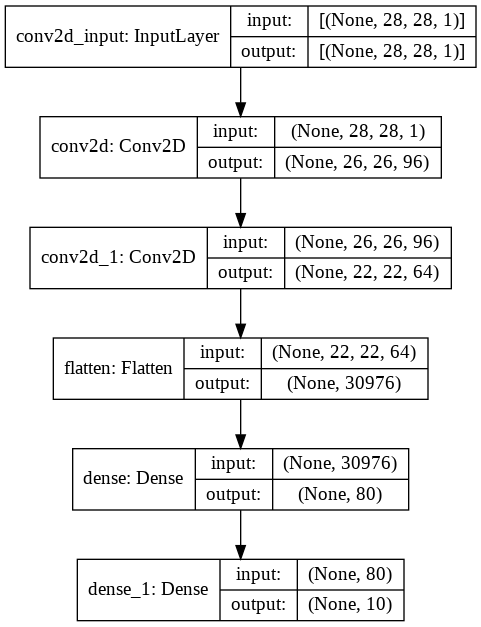

In [ ]:
# Visualise the model architecture 
plot_model(model, show_shapes=True)

In [ ]:
preds = model.predict(test_images)
pred = []

for i in range(len(preds)):
        pred.append(list(preds[i]).index(max(preds[i])))
    
print(f"Accuracy: {accuracy_score(test_labels, pred)*100}%")

Accuracy: 91.34%
